In [17]:
import numpy as np
from dataset.mnist import load_mnist


#### 학습

수치 미분 - 중심 차분 => 오차 줄이기

In [18]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [19]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

In [20]:
numerical_diff(function_1, np.array([5.0]))

array([0.2])

Gradient

In [21]:
numerical_diff(function_1, 5)

0.1999999999990898

In [22]:
def _numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # x와 같은 차원의 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad
        
        

In [23]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [24]:
print (_numerical_gradient(function_2, np.array([3.0, 4.0])))

[6. 8.]


### 경사하강법

In [25]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []
    
    for i in range(step_num):
        x_history.append(x.copy())
        
        grad = _numerical_gradient(f, x)
        x -= lr * grad
        
    return x, np.array(x_history)

In [26]:
init_x = np.array([-3.0, 4.0]) #NN이 시작할 때 초기값을 의미 함. (-3,4)에서 시작함 / 실제로는 랜덤 값을 줌
# 초기 값을 주는 방법에도 여러가지가 있음 Xavier, He 등이 있고 ReLU일 때 He를, Sigmoid면 Xavier를 쓰는게 좋다. (논문 기재)

lr = 0.1
step_num = 100
x, x_history = gradient_descent(function_2 ,init_x, lr=lr, step_num = step_num)
print (x)

[-6.11110793e-10  8.14814391e-10]


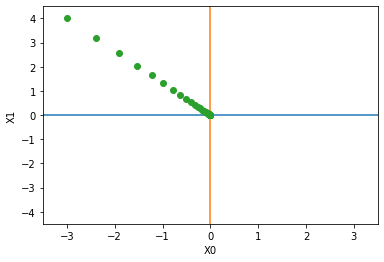

In [27]:
import matplotlib.pylab as plt

plt.plot([-5,5], [0,0])
plt.plot([0,0], [-5, 5])
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [28]:

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [29]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규 분포로 초기화
        
    def predict(self, x):
        return np.dot(x, self.W)
        
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
            
        return loss

In [30]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient(f, X)
    
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient(f, x)
            
        return grad

In [31]:
x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print (dW)

[[ 0.04832739  0.47580026 -0.52412765]
 [ 0.07249108  0.71370038 -0.78619147]]


In [32]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

In [33]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [34]:
network  = TwoLayerNet(input_size=784,hidden_size=50, output_size=1)
print(network.params['W1'].shape)
print(network.params['b1'].shape)
print(network.params['W2'].shape)
print(network.params['b2'].shape)

(784, 50)
(50,)
(50, 1)
(1,)


In [35]:
x = np.random.rand(100,784)
y = network.predict(x)

In [36]:
y[0]

array([1.])

train acc, test acc | 0.09085, 0.0851


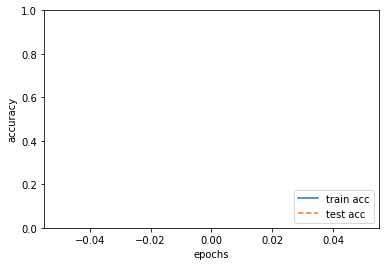

In [38]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 20  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [40]:
# BackPropagation

class MulLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

class AddLayer:
    def __init__(self):
        pass

    def forawrd(self, x ,y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [ ]:
apple = 100
num_apple = 2
tax = 1.1

# Feed Forawrd
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, num_apple)
price = mul_tax_layer.forward(apple_price, tax)

# Backpropagation
dprice = 1
dtax = mul_tax_layer.backward(dprice)